#Scrape VisualDX

In [ ]:
import json, requests, os, PIL.Image
from StringIO import StringIO

###Test Session Cookie

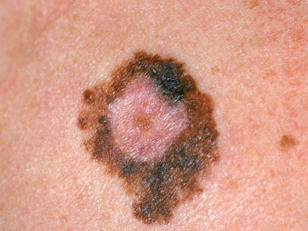

In [32]:
url = 'https://www.visualdx.com/visualdx/visualdx6/{}.do'
p = {'imageSize': 'Medium', 'imageId': 732416}
c = {'JSESSIONID': '20D60FFCA138E4F52AAEB60E2CCFDFA4.i1'}
r = requests.get(url.format('getImage'), params=p, cookies=c)
Image(r.content)

###Get List of Disease IDs

In [91]:
url = 'https://www.visualdx.com/visualdx/visualdx6/search.do'
p = {'q': 'a'}
dxIds = []
for dxId in xrange(50000, 56000):
    p['termIds'] = 'd-{}'.format(dxId)
    r = requests.get(url, params=p, cookies=c)
    clear_output(wait=True)
    display('checking dxId {}'.format(dxId), '{} dxIds found'.format(len(dxIds)))
    if 'did not match any diagnoses' not in r.content:
        dxIds.append(dxId)

with open('dxIds.json', 'w') as f: json.dump(dxIds, f)

'checking dxId 55999'

'1071 dxIds found'

###Find Images

In [7]:
diseases = []
I = []
p = {'q': 'a'}

with open('dxIds.json', 'r') as f: dxIds = json.load(f)

ctr = 0        

for dxId in dxIds:
    
    p['diagnosisId'] = dxId
    p['termIds'] = 'd-{}'.format(dxId)
    r = requests.get(url.format('search'), params=p, cookies=c)

    MIds = []
    for line in r.content.split('\r\n'):
        if 'dxModuleIds[' in line:
            MId = int(line.split()[-1][:-1])
            MIds.append(MId)
        if 'var dxName = ' in line:
            dname = line.split('"')[1]

    modules = []
    for MId in MIds:
        p['moduleId'] = MId
        r = requests.get(url.format('getDiagnosisText'), params=p, cookies=c)

        imageIds = []
        for line in r.content.split('\r\n'):
            if 'dxStacks[' in line:
                imageId = int(line.split()[-1][:-1])
                imageIds.append(imageId)
            if 'dxModuleNames[{}] = '.format(MId) in line:
                mname = line.split('"')[1] 

        module = {}
        module['MId'] = MId
        module['name'] = mname
        module['imageIds'] = imageIds
        modules.append(module)
        I += imageIds

    disease = {}
    disease['dxId'] = int(dxId)
    disease['name'] = dname
    disease['modules'] = modules
    diseases.append(disease)
    
    ctr += 1
    clear_output(wait=True)
    display('processed disease {}: {}'.format(ctr, dname))
    display('{} images found'.format(len(set(I))))

with open('diseases.json', 'w') as f: json.dump(diseases, f)

'processed disease 1071: Paederus Dermatitis'

'37208 images found'

###Download Images

In [34]:
ctr = 0
imageIds = list(set(I))

for i in imageIds:
    url = 'https://www.visualdx.com/visualdx/visualdx6/getImage.do'
    p = {'imageSize': 'Large', 'imageId': i}
    r = requests.get(url, params=p, cookies=c)
    f = 'images/{}.jpg'.format(i)
    PIL.Image.open(StringIO(r.content)).save(f)
    
    ctr += 1
    clear_output(wait=True)
    display('{} images downloaded'.format(ctr))

'25131 images downloaded'